In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

In [3]:
###mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the stock price data

In [4]:
stock_df= pd.read_csv('./drive/My Drive/Colab Notebooks/GME_stock.csv',parse_dates=["date"])

In [5]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666


In [6]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002


The data has inverted order by date. We need to change it in  date ascending order.

In [64]:
stock_df=stock_df.sort_values(by="date", ascending=True)
stock_df.reset_index(inplace=True)
stock_df.set_index('date',inplace=True)

In [65]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_lag4,close_price_tomorrow
date,,,,,,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,NaN,10.000
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,NaN,9.950
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,NaN,9.550
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,NaN,9.875
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,10.05,9.850


In [9]:
def create_lag_feature(df,orig_feature,lag):
  new_df=df.copy()
  new_feature_name= "%s_lag%d" %(orig_feature, lag)
  new_df[new_feature_name]=np.nan
  new_df.loc[df.index[lag:],new_feature_name]=df.iloc[:-lag][orig_feature].values
  return new_df

In [10]:
def create_after_days_target(df,orig_column,days_after):
  new_df= df.copy()
  target_column='%s_after_%d_days'%(orig_column, days_after)
  if days_after==1:
    target_column=orig_column +"_tomorrow"
  new_df[target_column]=np.nan
  new_df.loc[df.index[:-days_after],target_column]=df.iloc[days_after:][orig_column].values
  return new_df

In [11]:
stock_df=create_lag_feature(stock_df,'close_price',1) ## add feture: yesterday close_price

In [12]:
stock_df=create_lag_feature(stock_df,'close_price',2) ## add feture: close_price of 2 days before 

In [13]:
stock_df=create_lag_feature(stock_df,'close_price',3)  ## add feture: close_price of 3 days before 

In [14]:
stock_df=create_lag_feature(stock_df,'close_price',4)  ## add feture: close_price of 4 days before

In [15]:
## create target column "close_price_tomorrow"
stock_df=create_after_days_target(stock_df,'close_price',1)

In [16]:
stock_df.head()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_lag4,close_price_tomorrow
4772,2002-02-13,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,NaN,10.000
4771,2002-02-14,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,NaN,9.950
4770,2002-02-15,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,NaN,9.550
4769,2002-02-19,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,NaN,9.875
4768,2002-02-20,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,10.05,9.850


In [17]:
stock_df.tail()

,date,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_lag4,close_price_tomorrow
4,2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002,43.029999,39.119999,39.360001,35.500000,76.790001
3,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001,65.010002,43.029999,39.119999,39.360001,147.979996
2,2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996,76.790001,65.010002,43.029999,39.119999,347.510010
1,2021-01-27,354.829987,380.000000,249.000000,347.510010,93396700.0,347.510010,147.979996,76.790001,65.010002,43.029999,193.600006
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,58815800.0,193.600006,347.510010,147.979996,76.790001,65.010002,NaN


Split the dataframe into training set and test set


> there are some NaN values when we create new features and target columns. one way is to delete these column. the other way is to use SimpleImputer.
<br> lets just delete them first
<br> TODO, add SimpleImputer in preprocessing pipeline.



In [18]:
X=stock_df.iloc[4:4772,1:-1] ### not include the first 3 row and last raw with NAN values
Y=stock_df.iloc[4:4772,-1:]

In [19]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [20]:
X_scaled=scaler_X.fit_transform(X)
Y_scaled=scaler_Y.fit_transform(Y)

In [21]:
X_scaled.shape

(4768, 10)

In [22]:
train_size=ceil(X_scaled.shape[0]*0.8)
train_size

3815

In [66]:
stock_df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price,close_price_lag1,close_price_lag2,close_price_lag3,close_price_lag4,close_price_tomorrow
date,,,,,,,,,,,,
2002-02-13,4772,9.625,10.060,9.525,10.050,19054000.0,6.766666,NaN,NaN,NaN,NaN,10.000
2002-02-14,4771,10.175,10.195,9.925,10.000,2755400.0,6.733003,10.05,NaN,NaN,NaN,9.950
2002-02-15,4770,10.000,10.025,9.850,9.950,2097400.0,6.699336,10.00,10.05,NaN,NaN,9.550
2002-02-19,4769,9.900,9.900,9.375,9.550,1852600.0,6.430017,9.95,10.00,10.05,NaN,9.875
2002-02-20,4768,9.600,9.875,9.525,9.875,1723200.0,6.648838,9.55,9.95,10.00,10.05,9.850


In [71]:
dates_training = pd.to_datetime(stock_df.index[4:train_size+4])
dates_test = pd.to_datetime(stock_df.index[train_size+4:-1])

In [23]:
X_train, X_test= X_scaled[:train_size],X_scaled[train_size:]
Y_train, Y_test= Y_scaled[:train_size],Y_scaled[train_size:]

In [24]:
X_train.shape, X_test.shape

((3815, 10), (953, 10))

In [25]:
Y_train.shape, Y_test.shape

((3815, 1), (953, 1))

In [26]:
X_train;

array([[-0.95009929, -0.92892355, -0.97159477, ..., -0.9796566 ,
        -0.97642887, -0.97273574],
       [-0.93328516, -0.92554163, -0.95501019, ..., -1.00952683,
        -0.98016861, -0.97647897],
       [-0.92733015, -0.92554163, -0.96606653, ..., -0.98525726,
        -1.01008639, -0.98022221],
       ...,
       [-0.09538034, -0.0986645 , -0.07566049, ..., -0.10520502,
        -0.09086176, -0.09607292],
       [-0.06875787, -0.09663531, -0.06165572, ..., -0.08877643,
        -0.10432479, -0.09008377],
       [-0.077165  , -0.07904936, -0.05354781, ..., -0.07160093,
        -0.08787005, -0.1035594 ]])

In [27]:
Y_train;

array([[-0.92032385],
       [-0.93238154],
       [-0.92721397],
       ...,
       [-0.07835353],
       [-0.05699426],
       [-0.02185473]])

Build the BPNN model

In [28]:
model=Sequential()  
model.add(Dense(32,input_dim=10,kernel_initializer='uniform',activation='relu'))
model.add(Dense(8,kernel_initializer='uniform',activation='relu')) #中间层
model.add(Dense(1,activation='linear'))  ##输出层
model.summary()
#model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=0.01),metrics = ['mse', 'mae']) #编译模型
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(),metrics = ['mse', 'mae']) #编译模型
history=model.fit(X_train,
          Y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_test,Y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5514 - mse: 0.5514 - mae: 0.5271 - val_loss: 0.4533 - val_mse: 0.4533 - val_mae: 0.1230
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0640 - val_loss: 0.4224 - val_mse: 0.4224 - val_mae: 0.1097
Epoch 3/100
120/120 [==============================] - 0s 

In [99]:
model.save('/content/drive/MyDrive/BPNN_Model/BPNN_1_model.h5')

In [52]:
def model_loss(history):
  plt.figure(figsize=(11,7))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show();

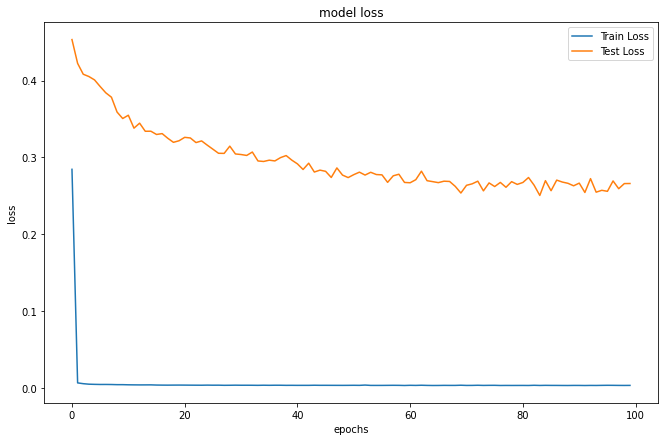

In [53]:
model_loss(history)

In [33]:
y_train_predict = model.predict(X_train)

Use scaler.inverse_transform to convert scaled y value to true price value

In [90]:
def prediction_plot(Y_actual,Y_predict,title,dates):
  plt.figure(figsize=(11,7))
  Y_actual=pd.DataFrame(Y_actual,index=dates)
  Y_predict=pd.DataFrame(Y_predict,index=dates)
  plt.plot(Y_actual,color= 'blue',label='actual')
  plt.plot(Y_predict, color= 'red',label='prediction')
  #plt.tight_layout()
  #sns.despine(top=True)
  #plt.subplots_adjust(left=0.07)
  plt.ylabel('stock_price',size=15)
  plt.xlabel('Date',size=15)
  plt.legend(fontsize=15)
  plt.title('Prediction VS Actual Tomorrow Close Price_'+title+'\n',size=15)
  plt.show()

In [48]:
y_pred_train=scaler_Y.inverse_transform(y_train_predict)
y_actual_train=scaler_Y.inverse_transform(Y_train)

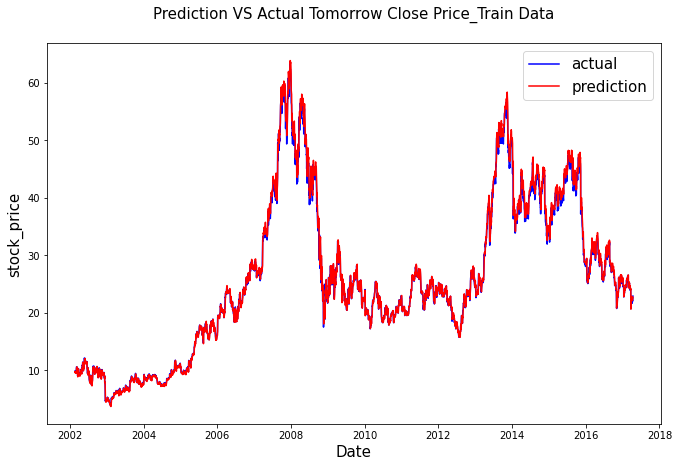

In [91]:
prediction_plot(y_actual_train,y_pred_train,'Train Data',dates_training)

In [37]:
y_test_predict=model.predict(X_test)
y_pred_test=scaler_Y.inverse_transform(y_test_predict)
y_actual_test=scaler_Y.inverse_transform(Y_test)

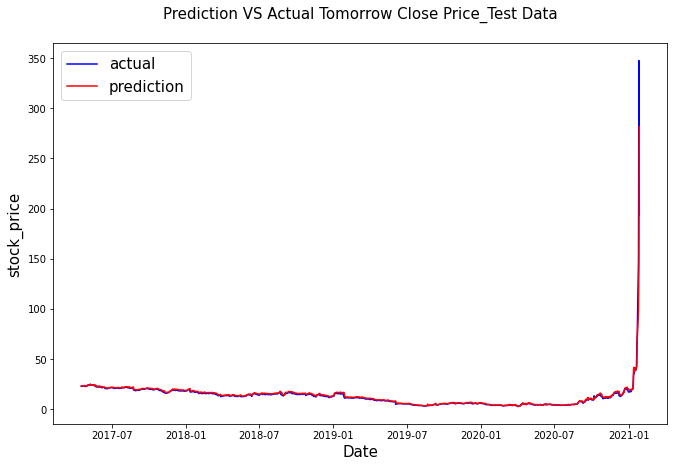

In [100]:
prediction_plot(y_actual_test,y_pred_test,'Test Data',dates_test)

The test set has a unexpected sharp increase in the last 11 days, which would increase the MSE and MAE of test data.

The Three metrics:

In [44]:
RMSE_train = np.sqrt(mean_squared_error(y_actual_train,y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_actual_test,y_pred_test))
print('The root mean square error (RMSE) for the train data is %.3f'%RMSE_train)
print('The root mean square error (RMSE) for the test data is %.3f'%RMSE_test)

The root mean square error (RMSE) for the train data is 0.912
The root mean square error (RMSE) for the test data is 7.485


In [41]:
MAE_train = mean_absolute_error(y_actual_train,y_pred_train)
MAE_test = mean_absolute_error(y_actual_test,y_pred_test)
print('The mean absolute error (MAE) for the train data is %.3f'%MAE_train)
print('The mean absolute error (MAE) for the test data is %.3f'%MAE_test)

The mean absolute error (MAE) for the train data is 0.585
The mean absolute error (MAE) for the test data is 1.057


In [42]:
R2_train = r2_score(y_actual_train,y_pred_train)
R2_test = r2_score(y_actual_test,y_pred_test)
print('The coefficient of determination (R^2) for the train data is %.3f'% R2_train)
print('The coefficient of determination (R^2) for the test data is %.3f'% R2_test)

The coefficient of determination (R^2) for the train data is 0.995
The coefficient of determination (R^2) for the test data is 0.745


In [43]:
y_var_test=y_actual_test[1:]-y_actual_test[:len(y_actual_test)-1]
y_var_predict=y_pred_test[1:]-y_pred_test[:len(y_pred_test)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('up and down direction accuracy: %.3f'%result)

up and down direction accuracy: 0.500


**Remove the last 11 data (they are increased suddenly)**

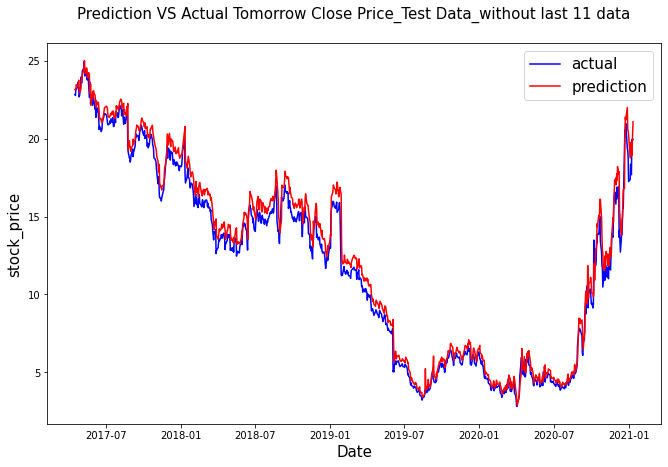

In [93]:
prediction_plot(y_actual_test[:-11],y_pred_test[:-11],'Test Data_without last 11 data',dates_test[:-11])

In [55]:
RMSE_test = np.sqrt(mean_squared_error(y_actual_test[:-11],y_pred_test[:-11]))
print('The root mean square error (RMSE) for the test data(without last 11 data) is %.3f'%RMSE_test)

The root mean square error (RMSE) for the test data(without last 11 data) is 0.819


In [56]:
MAE_test = mean_absolute_error(y_actual_test[:-11],y_pred_test[:-11])
print('The mean absolute error (MAE) for the test data(without last 11 data) is %.3f'%MAE_test)

The mean absolute error (MAE) for the test data(without last 11 data) is 0.644


In [57]:
R2_test = r2_score(y_actual_test[:-11],y_pred_test[:-11])
print('The coefficient of determination (R^2) for the test data(without last 11 data) is %.3f'% R2_test)

The coefficient of determination (R^2) for the test data(without last 11 data) is 0.982


In [60]:
y_actual_test_sub=y_actual_test[:-11]
y_pred_test_sub=y_pred_test[:-11]
y_var_test=y_actual_test_sub[1:]-y_actual_test_sub[:len(y_actual_test_sub)-1]
y_var_predict=y_pred_test_sub[1:]-y_pred_test_sub[:len(y_pred_test_sub)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test)-1):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('up and down direction accuracy(without last 11 data): %.3f'%result)

up and down direction accuracy(without last 11 data): 0.499
